In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scipy import stats
import statsmodels.formula.api as smf

import cellspec as spc

In [ ]:
np.random.uniform(1,100)

In [2]:
adata = spc.pp.load_vcf('../data/worm_mut_accumulation_ncbi/worm_N2_N3_Pole1_ncbi_joint.vcf.gz')
adata

Loading VCF: 1662439 sites [00:35, 47256.22 sites/s]
/loc/scratch/45608103/ipykernel_24435/3194553727.py:1: UserWarning: Found 15258 duplicate variant records in VCF (same CHROM-POS-REF>ALT). Kept first occurrence of each. Consider deduplicating your VCF with: bcftools norm -d exact input.vcf.gz -Oz -o output.vcf.gz
  adata = spc.pp.load_vcf('../data/worm_mut_accumulation_ncbi/worm_N2_N3_Pole1_ncbi_joint.vcf.gz')


Building matrices for 1647181 sites × 17 samples...
Converting to sparse format...
Done! Loaded 1647181 sites × 17 samples


AnnData object with n_obs × n_vars = 17 × 1647181
    uns: 'vcf_source', 'n_variants', 'n_cells'
    layers: 'DP', 'AD'

In [3]:
# adata.write_h5ad('../results/worm_mut_accumulation/bulk_worm_raw.h5ad')

In [4]:
adata.obs_names = adata.obs.index.map(os.path.basename).str[:-4]

In [5]:
obs = {
    'N2_G0':['WT',None,0],
    'Pole-1_P0':['P270R',None,0],
    'N2_P2G1':['WT','P2',1],
    'N2_P2G2':['WT','P2',2],
    'N2_P2G3':['WT','P2',3],
    'N2_P3G1':['WT','P3',1],
    'N2_P3G2':['WT','P3',2],
    'N2_P3G3':['WT','P3',3],
    'N3_P4G1':['WT','P4',1],
    'N3_P4G2':['WT','P4',2],
    'N3_P4G3':['WT','P4',3],
    'Pole-1_P1G1':['P270R','P1',1],
    'Pole-1_P1G2':['P270R','P1',2],
    'Pole-1_P1G3':['P270R','P1',3],
    'Pole-1_P2G1':['P270R','P2',1],
    'Pole-1_P2G2':['P270R','P2',2],
    'Pole-1_P2G3':['P270R','P2',3]
}
adata.obs = pd.DataFrame.from_dict(obs, orient='index', columns=['Mutation','Replicate','Split'])

In [6]:
# Load sequencing run coverage stats
adata.obs[['mean_coverage', 'callable_Mb_10x']] = pd.read_csv('../data/worm_mut_accumulation_ncbi/coverage_summary.tsv', sep='\t', index_col='sample')[['mean_coverage', 'callable_Mb_10x']]


In [7]:
## Filter out non snps
spc.pp.filter_to_snps(adata, inplace=True)

In [8]:
# Filter out sites without sufficient coverage in all samples
spc.pp.filter_by_coverage(adata, min_depth=10)

In [9]:
spc.pp.annotate_contexts(adata, fasta_path='../data/reference/worm_GCA_028201515.1/GCA_028201515.1_genomic.fna')
# adata.var

Annotating trinuc contexts: 100%|██████████| 1630882/1630882 [00:19<00:00, 82139.90 sites/s]


## Basic Stats
- depth
- mutations per sample
- VAF in bulk

In [21]:
adata.var['tot_depth_bulk'] = np.ravel(adata.layers['DP'].sum(axis=0))

<Axes: xlabel='Depth accross samples', ylabel='Count of Sites'>

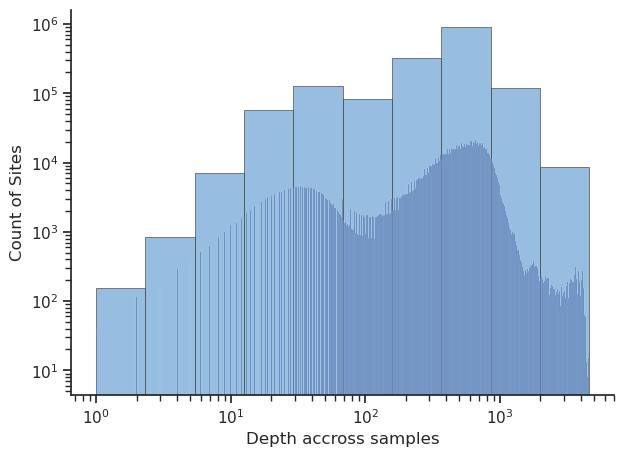

In [43]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='tot_depth_bulk', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("Depth accross samples", fontsize=12)
plt.ylabel("Count of Sites", fontsize=12)

sns.histplot(np.ravel(adata.layers['DP'].sum(axis=0)), log=True)

In [23]:
spc.tl.compute_bulk_vaf(adata,
                        target_dp=100
                       )

Text(0, 0.5, 'Count of Sites')

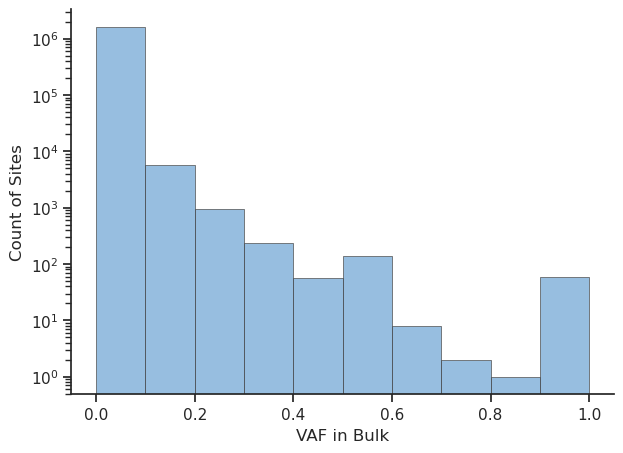

In [29]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='bulk_vaf', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             # log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("VAF in Bulk", fontsize=12)
plt.ylabel("Count of Sites", fontsize=12)

In [36]:
adata.obs['snp_count'] = np.ravel((adata.X>0).sum(axis=1))

In [37]:
adata.obs['snp_count'].mean()

np.float64(223514.29411764705)

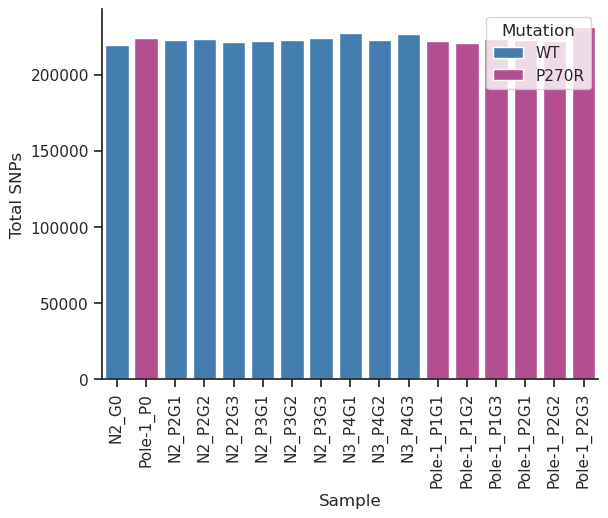

In [38]:
sns.barplot(data=adata.obs, x=adata.obs.index, y='snp_count', hue='Mutation', palette={'WT':'#317EC2','P270R':'#C43E96'})
plt.xlabel("Sample", fontsize=12)
plt.ylabel("Total SNPs", fontsize=12)
plt.xticks(rotation=90)
sns.despine()

## Private mutations 
- Look at quantity of mutations that are unique to each sample

In [40]:
spc.tl.private_mutations(
      adata,
      count_strategy='presence',
      store_key='private'
)

,N2_G0,Pole-1_P0,N2_P2G1,N2_P2G2,N2_P2G3,N2_P3G1,N2_P3G2,N2_P3G3,N3_P4G1,N3_P4G2,N3_P4G3,Pole-1_P1G1,Pole-1_P1G2,Pole-1_P1G3,Pole-1_P2G1,Pole-1_P2G2,Pole-1_P2G3
CP116366.1-1-G>T,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CP116366.1-2-C>G,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CP116366.1-2-C>A,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CP116366.1-2-C>T,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CP116366.1-3-C>A,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CP116366.1-3678139-T>A,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CP116366.1-3678140-A>T,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CP116366.1-3678142-T>A,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CP116366.1-3678148-A>T,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [41]:
adata.obs['private_count_per_callable_mb'] = adata.obs['private_count'] / adata.obs['callable_Mb_10x']

In [42]:
adata.obs['private_count'].mean()

np.float64(11237.29411764706)

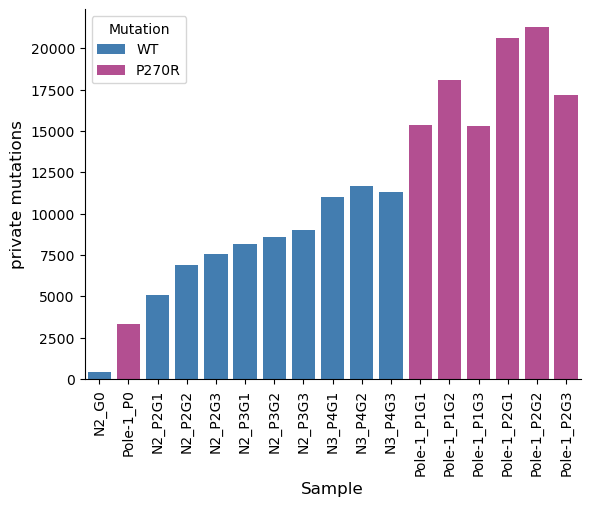

In [12]:
sns.barplot(data=adata.obs, x=adata.obs.index, y='private_count', hue='Mutation', palette={'WT':'#317EC2','P270R':'#C43E96'})
plt.xlabel("Sample", fontsize=12)
plt.ylabel("private mutations", fontsize=12)
plt.xticks(rotation=90)
sns.despine()

## Pole-1 site mutation status:


## Mutation Accumulation

In [20]:
lineages = {
    'P270R_P1': ['Pole-1_P0', 'Pole-1_P1G1', 'Pole-1_P1G2', 'Pole-1_P1G3'],
    'P270R_P2': ['Pole-1_P0', 'Pole-1_P2G1', 'Pole-1_P2G2', 'Pole-1_P2G3'],
    'WT_P2': ['N2_G0', 'N2_P2G1', 'N2_P2G2', 'N2_P2G3'],
    'WT_P3': ['N2_G0', 'N2_P3G1', 'N2_P3G2', 'N2_P3G3'],
    'WT_P4': ['N2_G0', 'N3_P4G1', 'N3_P4G2', 'N3_P4G3'],
}

In [21]:
def compute_accumulated_mutations(adata, lineages):
    """
    Compute accumulated mutations along lineage branches.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with genotype calls in .X (>0 = variant present)
    lineages : dict
        Dictionary mapping lineage names to lists of sample names, ordered by generation.
        The first sample is treated as G0/ancestor.
        e.g., {'P270R_P1': ['Pole-1_P0', 'Pole-1_P1G1', 'Pole-1_P1G2', 'Pole-1_P1G3']}
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: Lineage, Split, Samples, Shared_Variants, Accumulated_Mutations
    """
    results = []
    
    for lineage_name, samples in lineages.items():
        samples = list(samples)
        
        # Each split point: from that generation onward
        split_points = []
        for i in range(len(samples)):
            remaining = samples[i:]
            split_points.append((i, remaining))
        
        # Compute shared variant counts
        shared_counts = {}
        sample_labels = {}
        for split_num, sample_set in split_points:
            subset = adata[sample_set, :]
            n_shared = np.ravel((subset.X > 0).sum(axis=0) == len(sample_set)).sum()
            shared_counts[split_num] = n_shared
            sample_labels[split_num] = sample_set
        
        # Compute accumulated (delta from baseline, which is split 0)
        baseline = shared_counts[0]
        for split_num in sorted(shared_counts.keys()):
            results.append({
                'Lineage': lineage_name,
                'Split': split_num,
                'Samples': sample_labels[split_num],
                'Shared_Variants': shared_counts[split_num],
                'Accumulated_Mutations': shared_counts[split_num] - baseline
            })
    
    return pd.DataFrame(results)

In [22]:
time_series = compute_accumulated_mutations(adata, lineages)
time_series = time_series.assign(
    Clone=lambda x: x['Lineage'].str.split('_').str[1],
    Genotype=lambda x: x['Lineage'].str.split('_').str[0]
)

Text(48.195016927083344, 0.5, 'Accumulated Mutations')

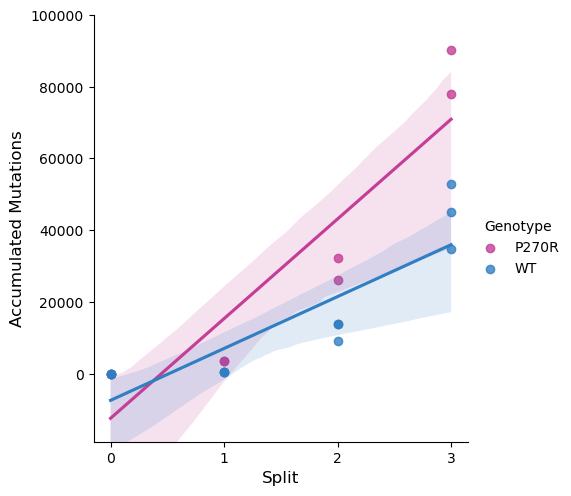

In [23]:
## Plot
g = sns.lmplot(time_series, x='Split',y='Accumulated_Mutations',
           palette={'WT':'#317EC2','P270R':'#C43E96'},
           hue='Genotype'
        )

new_ticks = [0,1,2,3]
new_labels = ['0','1','2','3']
g.set(xticks=new_ticks, xticklabels=new_labels)
plt.ylim(-19000,100000)
plt.xlabel("Split", fontsize=12)
plt.ylabel("Accumulated Mutations", fontsize=12)

In [24]:
g.savefig('../results/worm_mut_accumulation/mutations_vs_time.png')

In [25]:
time_series.to_csv('../results/worm_mut_accumulation/mutations.csv')

In [26]:
df = time_series
df['CloneID'] = df['Genotype'] + '_' + df['Clone'].astype(str)
df['Genotype'] = pd.Categorical(df['Genotype'], categories=['WT', 'P270R'])

In [27]:
print("\n" + "="*70)
print("MIXED EFFECTS MODEL")
print("="*70)
print("\nModel: Accumulated_Mutations ~ Split * Genotype + (Split | CloneID)")

# Random intercept + slope model
model = smf.mixedlm(
    "Accumulated_Mutations ~ Split * Genotype",
    data=df,
    groups=df["CloneID"],
    re_formula="~Split"
)
result = model.fit(method=['lbfgs', 'powell', 'cg'])

print("\n" + str(result.summary()))


MIXED EFFECTS MODEL

Model: Accumulated_Mutations ~ Split * Genotype + (Split | CloneID)

                   Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Accumulated_Mutations
No. Observations:    20         Method:                REML                 
No. Groups:          5          Scale:                 147620793.7926       
Min. group size:     4          Log-Likelihood:        -177.9718            
Max. group size:     4          Converged:             Yes                  
Mean group size:     4.0                                                    
----------------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|   [0.025     0.975] 
----------------------------------------------------------------------------
Intercept               -7462.400 5868.974 -1.271 0.204 -18965.377  4040.577
Genotype[T.P270R]       -5008.500 9279.662 -0.540 0.589 -23196.304 13179.304
Split

/home/dmullane/micromamba/envs/default_jupyter/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dmullane/micromamba/envs/default_jupyter/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with powell
  warnings.warn(
/home/dmullane/micromamba/envs/default_jupyter/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [28]:
# Extract key coefficients
print("\n" + "-"*70)
print("KEY COEFFICIENTS:")
print("-"*70)
print(f"WT baseline rate (Generation):           {result.fe_params['Split']:,.0f} mutations/split")
print(f"P270R additional rate (Gen:Genotype):    {result.fe_params['Split:Genotype[T.P270R]']:,.0f} mutations/split")
print(f"P270R total rate:                        {result.fe_params['Split'] + result.fe_params['Split:Genotype[T.P270R]']:,.0f} mutations/split")
print(f"\nInteraction p-value: {result.pvalues['Split:Genotype[T.P270R]']:.2e}")



----------------------------------------------------------------------
KEY COEFFICIENTS:
----------------------------------------------------------------------
WT baseline rate (Generation):           14,467 mutations/split
P270R additional rate (Gen:Genotype):    13,331 mutations/split
P270R total rate:                        27,798 mutations/split

Interaction p-value: 7.20e-03


In [29]:
print("\n" + "="*70)
print("PER-CLONE REGRESSION LINES")
print("="*70)

clone_stats = []
for clone in df['CloneID'].unique():
    clone_data = df[df['CloneID'] == clone].sort_values('Split')
    genotype = clone_data['Genotype'].iloc[0]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        clone_data['Split'],
        clone_data['Accumulated_Mutations']
    )
    
    clone_stats.append({
        'CloneID': clone,
        'Genotype': genotype,
        'Slope': slope,
        'Intercept': intercept,
        'R_squared': r_value**2,
        'Slope_SE': std_err
    })

clone_df = pd.DataFrame(clone_stats)
print("\n", clone_df.to_string(index=False))

# Summary by genotype
print("\n" + "-"*70)
print("SUMMARY BY GENOTYPE:")
print("-"*70)

for geno in ['WT', 'P270R']:
    subset = clone_df[clone_df['Genotype'] == geno]
    print(f"\n{geno}:")
    print(f"  Slope (mean ± SD):     {subset['Slope'].mean():>10,.0f} ± {subset['Slope'].std():,.0f}")
    print(f"  Intercept (mean ± SD): {subset['Intercept'].mean():>10,.0f} ± {subset['Intercept'].std():,.0f}")

# Fold change
wt_rate = clone_df[clone_df['Genotype'] == 'WT']['Slope'].mean()
p270r_rate = clone_df[clone_df['Genotype'] == 'P270R']['Slope'].mean()
print(f"\nFold change (P270R / WT): {p270r_rate / wt_rate:.2f}x")



PER-CLONE REGRESSION LINES

  CloneID Genotype   Slope  Intercept  R_squared    Slope_SE
P270R_P1    P270R 25647.4   -11542.6   0.848794 7654.415413
P270R_P2    P270R 29948.3   -13399.2   0.857796 8622.266003
   WT_P2       WT 11274.3    -5880.7   0.795101 4047.007639
   WT_P3       WT 14910.6    -7495.4   0.822498 4897.947399
   WT_P4       WT 17215.9    -9011.1   0.795291 6176.177335

----------------------------------------------------------------------
SUMMARY BY GENOTYPE:
----------------------------------------------------------------------

WT:
  Slope (mean ± SD):         14,467 ± 2,996
  Intercept (mean ± SD):     -7,462 ± 1,565

P270R:
  Slope (mean ± SD):         27,798 ± 3,041
  Intercept (mean ± SD):    -12,471 ± 1,313

Fold change (P270R / WT): 1.92x


In [30]:
print("\n" + "="*70)
print("STATISTICAL TESTS ON SLOPES")
print("="*70)

wt_slopes = clone_df[clone_df['Genotype'] == 'WT']['Slope']
p270r_slopes = clone_df[clone_df['Genotype'] == 'P270R']['Slope']

# Welch's t-test
t_stat, p_ttest = stats.ttest_ind(p270r_slopes, wt_slopes, equal_var=False)
print(f"\nWelch's t-test: t = {t_stat:.3f}, p = {p_ttest:.4f}")


STATISTICAL TESTS ON SLOPES

Welch's t-test: t = 4.831, p = 0.0320


## Mutation Accumulation (no G0)

- we don't really know what the G0 and P0 samples are and why there isn't a different one for each replicate, so seeing what things look like when they are excluded

In [37]:
adata = adata[~adata.obs_names.isin(['N2_G0','Pole-1_P0']),:]

In [38]:
lineages = {
    'P270R_P1': ['Pole-1_P1G1', 'Pole-1_P1G2', 'Pole-1_P1G3'],
    'P270R_P2': ['Pole-1_P2G1', 'Pole-1_P2G2', 'Pole-1_P2G3'],
    'WT_P2': ['N2_P2G1', 'N2_P2G2', 'N2_P2G3'],
    'WT_P3': ['N2_P3G1', 'N2_P3G2', 'N2_P3G3'],
    'WT_P4': ['N3_P4G1', 'N3_P4G2', 'N3_P4G3'],
}

In [39]:
def compute_accumulated_mutations(adata, lineages):
    """
    Compute accumulated mutations along lineage branches.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with genotype calls in .X (>0 = variant present)
    lineages : dict
        Dictionary mapping lineage names to lists of sample names, ordered by generation.
        The first sample is treated as G0/ancestor.
        e.g., {'P270R_P1': ['Pole-1_P0', 'Pole-1_P1G1', 'Pole-1_P1G2', 'Pole-1_P1G3']}
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: Lineage, Split, Samples, Shared_Variants, Accumulated_Mutations
    """
    results = []
    
    for lineage_name, samples in lineages.items():
        samples = list(samples)
        
        # Each split point: from that generation onward
        split_points = []
        for i in range(len(samples)):
            remaining = samples[i:]
            split_points.append((i, remaining))
        
        # Compute shared variant counts
        shared_counts = {}
        sample_labels = {}
        for split_num, sample_set in split_points:
            subset = adata[sample_set, :]
            n_shared = np.ravel((subset.X > 0).sum(axis=0) == len(sample_set)).sum()
            shared_counts[split_num] = n_shared
            sample_labels[split_num] = sample_set
        
        # Compute accumulated (delta from baseline, which is split 0)
        baseline = shared_counts[0]
        for split_num in sorted(shared_counts.keys()):
            results.append({
                'Lineage': lineage_name,
                'Split': split_num,
                'Samples': sample_labels[split_num],
                'Shared_Variants': shared_counts[split_num],
                'Accumulated_Mutations': shared_counts[split_num] - baseline
            })
    
    return pd.DataFrame(results)

In [40]:
time_series = compute_accumulated_mutations(adata, lineages)
time_series = time_series.assign(
    Clone=lambda x: x['Lineage'].str.split('_').str[1],
    Genotype=lambda x: x['Lineage'].str.split('_').str[0]
)

In [41]:
time_series

,Lineage,Split,Samples,Shared_Variants,Accumulated_Mutations,Clone,Genotype
0,P270R_P1,0,"[Pole-1_P1G1, Pole-1_P1G2, Pole-1_P1G3]",149208,0,P1,P270R
1,P270R_P1,1,"[Pole-1_P1G2, Pole-1_P1G3]",171814,22606,P1,P270R
2,P270R_P1,2,[Pole-1_P1G3],223588,74380,P1,P270R
3,P270R_P2,0,"[Pole-1_P2G1, Pole-1_P2G2, Pole-1_P2G3]",144769,0,P2,P270R
4,P270R_P2,1,"[Pole-1_P2G2, Pole-1_P2G3]",173370,28601,P2,P270R
5,P270R_P2,2,[Pole-1_P2G3],231464,86695,P2,P270R
6,WT_P2,0,"[N2_P2G1, N2_P2G2, N2_P2G3]",187169,0,P2,WT
7,WT_P2,1,"[N2_P2G2, N2_P2G3]",195794,8625,P2,WT
8,WT_P2,2,[N2_P2G3],221479,34310,P2,WT
9,WT_P3,0,"[N2_P3G1, N2_P3G2, N2_P3G3]",179363,0,P3,WT


Text(48.195016927083344, 0.5, 'Accumulated Mutations')

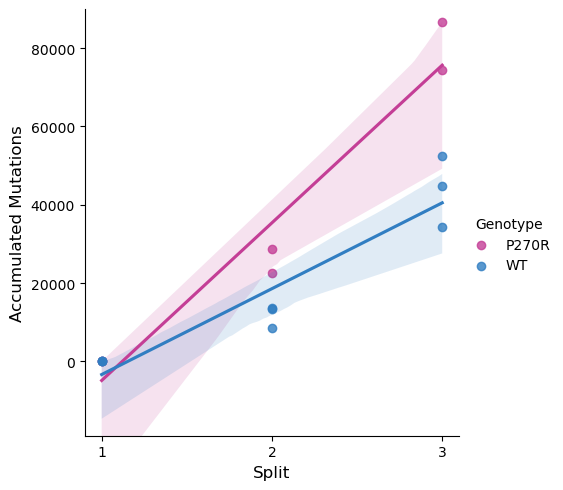

In [45]:
## Plot
g = sns.lmplot(time_series, x='Split',y='Accumulated_Mutations',
           palette={'WT':'#317EC2','P270R':'#C43E96'},
           hue='Genotype'
        )

new_ticks = [0,1,2]
new_labels = ['1','2','3']
g.set(xticks=new_ticks, xticklabels=new_labels)
plt.ylim(-19000,90000)
plt.xlabel("Split", fontsize=12)
plt.ylabel("Accumulated Mutations", fontsize=12)

In [46]:
# g.savefig('../results/worm_mut_accumulation/mutations_vs_time.png')

In [47]:
# time_series.to_csv('../results/worm_mut_accumulation/mutations.csv')

In [48]:
df = time_series
df['CloneID'] = df['Genotype'] + '_' + df['Clone'].astype(str)
df['Genotype'] = pd.Categorical(df['Genotype'], categories=['WT', 'P270R'])

In [49]:
print("\n" + "="*70)
print("MIXED EFFECTS MODEL")
print("="*70)
print("\nModel: Accumulated_Mutations ~ Split * Genotype + (Split | CloneID)")

# Random intercept + slope model
model = smf.mixedlm(
    "Accumulated_Mutations ~ Split * Genotype",
    data=df,
    groups=df["CloneID"],
    re_formula="~Split"
)
result = model.fit(method=['lbfgs', 'powell', 'cg'])

print("\n" + str(result.summary()))


MIXED EFFECTS MODEL

Model: Accumulated_Mutations ~ Split * Genotype + (Split | CloneID)

                     Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Accumulated_Mutations
No. Observations:     15          Method:                 REML                 
No. Groups:           5           Scale:                  62436298.3636        
Min. group size:      3           Log-Likelihood:         -118.4442            
Max. group size:      3           Converged:              Yes                  
Mean group size:      3.0                                                      
-------------------------------------------------------------------------------
                           Coef.     Std.Err.   z    P>|z|   [0.025     0.975] 
-------------------------------------------------------------------------------
Intercept                 -3367.333  4166.973 -0.808 0.419 -11534.449  4799.783
Genotype[T.P270R]         -1521.083  6588.562 -0.2

/home/dmullane/micromamba/envs/default_jupyter/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [50]:
# Extract key coefficients
print("\n" + "-"*70)
print("KEY COEFFICIENTS:")
print("-"*70)
print(f"WT baseline rate (Generation):           {result.fe_params['Split']:,.0f} mutations/split")
print(f"P270R additional rate (Gen:Genotype):    {result.fe_params['Split:Genotype[T.P270R]']:,.0f} mutations/split")
print(f"P270R total rate:                        {result.fe_params['Split'] + result.fe_params['Split:Genotype[T.P270R]']:,.0f} mutations/split")
print(f"\nInteraction p-value: {result.pvalues['Split:Genotype[T.P270R]']:.2e}")



----------------------------------------------------------------------
KEY COEFFICIENTS:
----------------------------------------------------------------------
WT baseline rate (Generation):           21,929 mutations/split
P270R additional rate (Gen:Genotype):    18,339 mutations/split
P270R total rate:                        40,269 mutations/split

Interaction p-value: 9.86e-04


In [52]:
print("\n" + "="*70)
print("STATISTICAL TESTS ON SLOPES")
print("="*70)

wt_slopes = clone_df[clone_df['Genotype'] == 'WT']['Slope']
p270r_slopes = clone_df[clone_df['Genotype'] == 'P270R']['Slope']

# Welch's t-test
t_stat, p_ttest = stats.ttest_ind(p270r_slopes, wt_slopes, equal_var=False)
print(f"\nWelch's t-test: t = {t_stat:.3f}, p = {p_ttest:.4f}")


STATISTICAL TESTS ON SLOPES

Welch's t-test: t = 4.529, p = 0.0330


## Mutation Spectrum

In [31]:
groups = {
    "P270R_P1_G0G1G2G3":['Pole-1_P0','Pole-1_P1G1','Pole-1_P1G2','Pole-1_P1G3'],
    "P270R_P2_G0G1G2G3":['Pole-1_P0','Pole-1_P2G1','Pole-1_P2G2','Pole-1_P2G3'],
    "WT_P2_G0G1G2G3":['N2_G0','N2_P2G1','N2_P2G2','N2_P2G3'],
    "WT_P3_G0G1G2G3":['N2_G0','N2_P3G1','N2_P3G2','N2_P3G3'],
    "WT_P4_G0G1G2G3":['N2_G0','N3_P4G1','N3_P4G2','N3_P4G3'],
}
for name,samples in groups.items():
    subset = adata[samples,:]
    adata.var[f"{name}_shared"] = np.ravel((subset.X>0).sum(axis=0)==len(samples))

shared = {
    "P270R_shared":((adata.var['P270R_P1_G0G1G2G3_shared']==True)|(adata.var['P270R_P2_G0G1G2G3_shared']==True)),
    "WT_shared":((adata.var['WT_P2_G0G1G2G3_shared']==True)|(adata.var['WT_P3_G0G1G2G3_shared']==True)|(adata.var['WT_P4_G0G1G2G3_shared']==True))
}

In [32]:
adata.var["P270R_shared"] = shared["P270R_shared"]
adata.var["WT_shared"] = shared["WT_shared"]


In [34]:
P270R_shared_spectrum = spc.tl.compute_spectrum_from_mask(adata, 'P270R_shared')
WT_shared_spectrum = spc.tl.compute_spectrum_from_mask(adata, 'WT_shared')

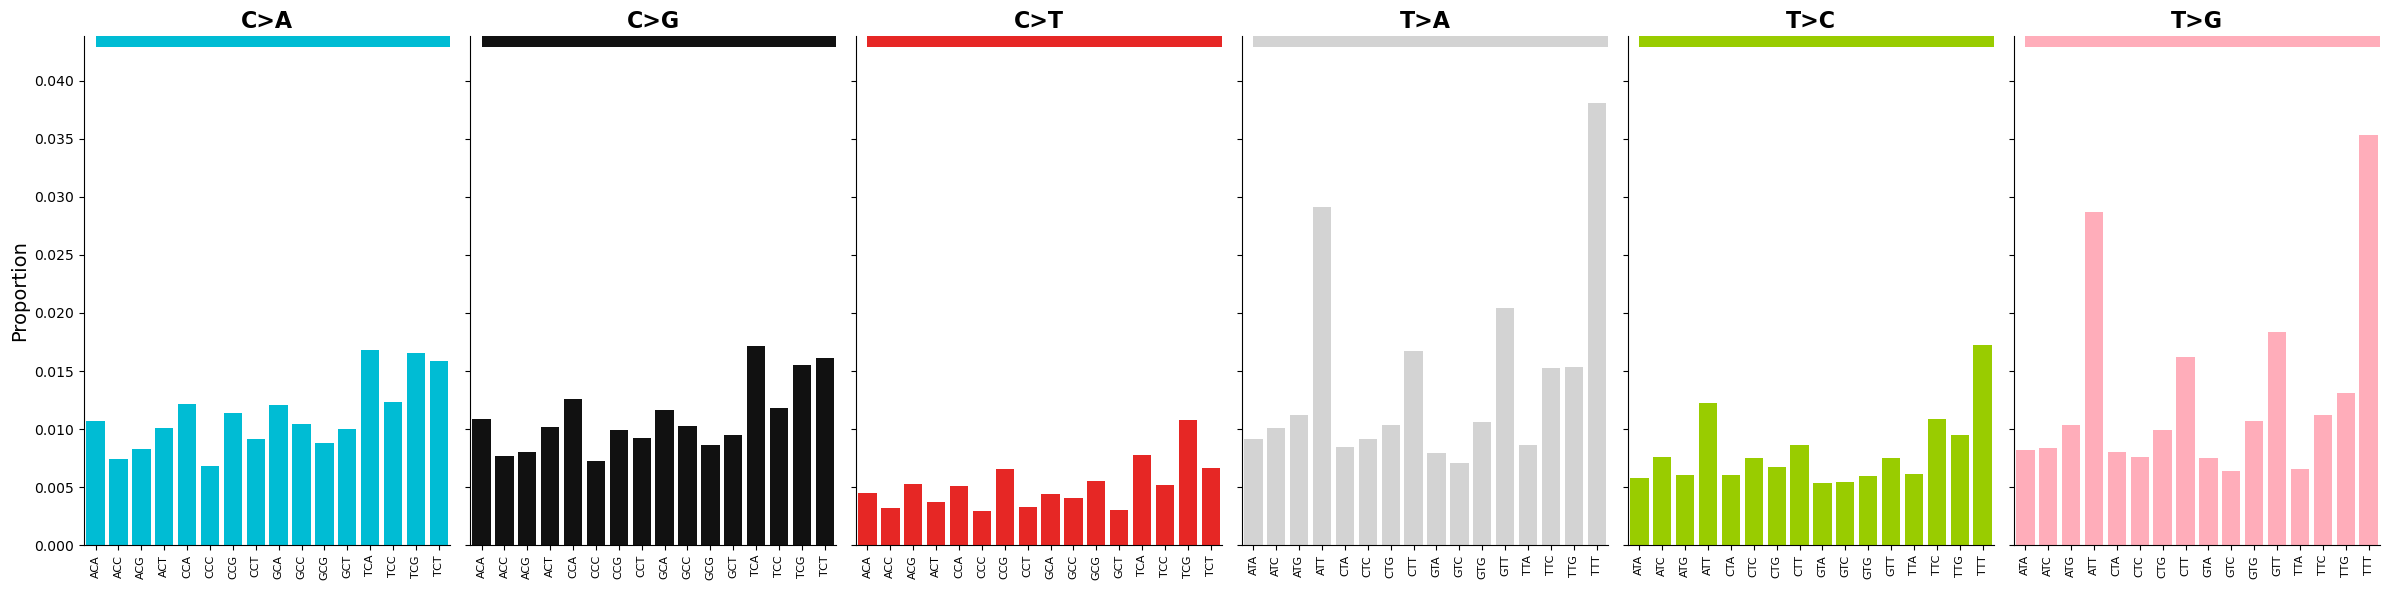

In [35]:
spc.pl.spectrum_from_df(WT_shared_spectrum, normalize=True)

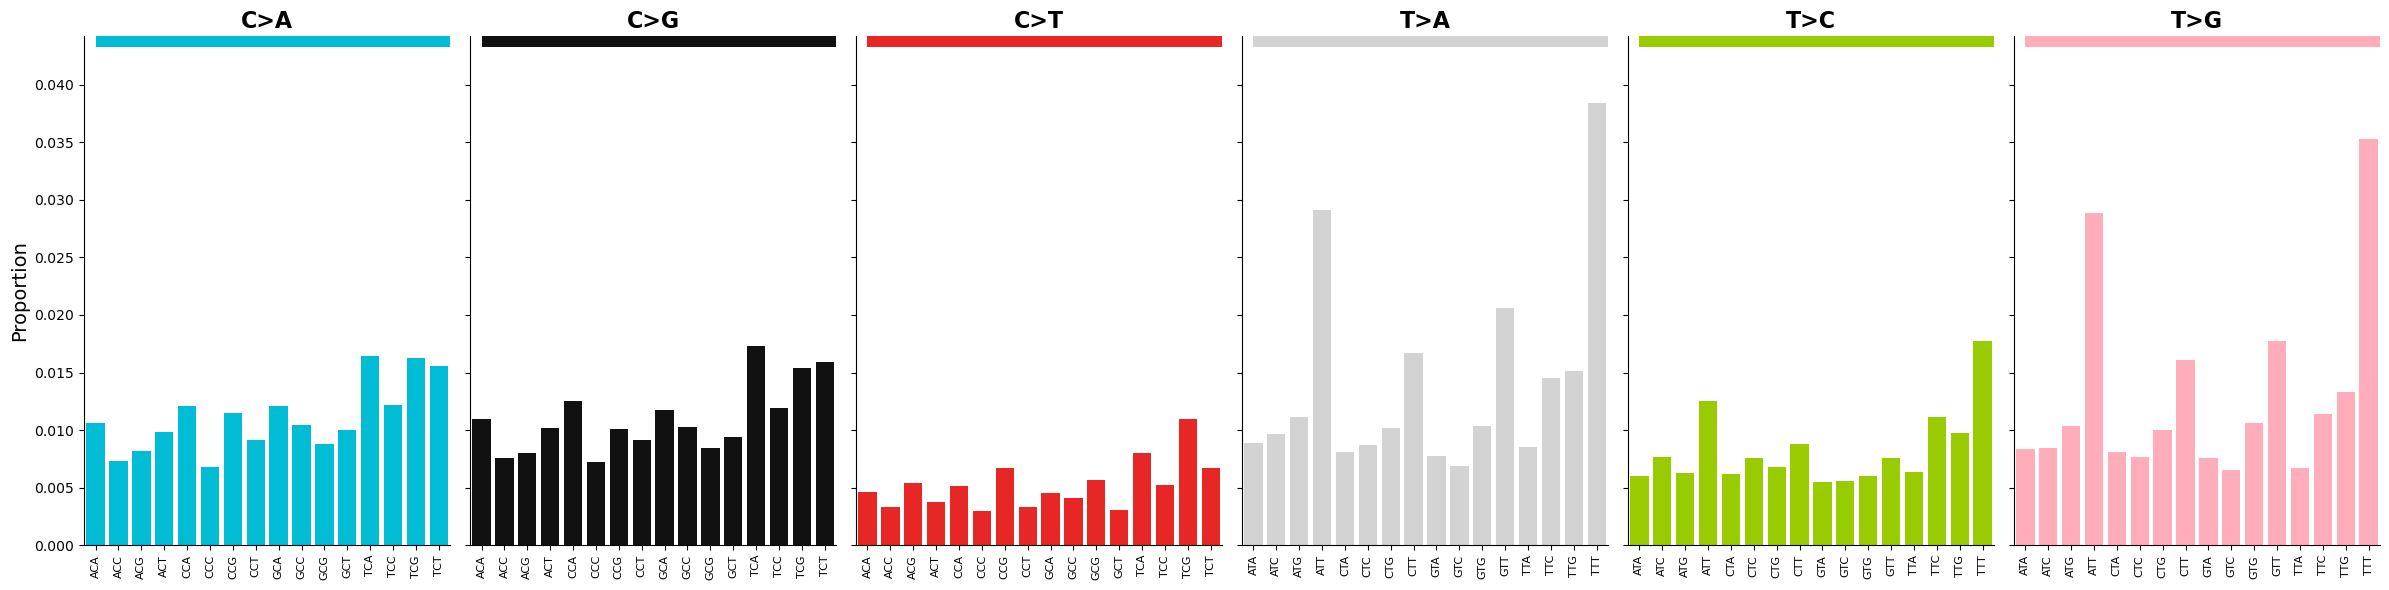

In [36]:
spc.pl.spectrum_from_df(P270R_shared_spectrum, normalize=True)